# MEPs in diseased vs healthy mice

In [1]:
from tqdm import tqdm
from mepextract.extracting import Extractor
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
import pickle
import json

plt.style.use(['science', 'grid'])

## defining relevant folders and paths

In [21]:
spreadsheet = pd.read_csv('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/mep_sciatic.csv')

master_folder = '/Volumes/STORAGE 1.0/UNIC Research/Motor Evoked Potentials/motor_evoked_potentials_dataspell/MEPSSEP_raw_data'

spreadsheet.loc[0]

index                             37
session          2024-03-02 11:08:17
animalID                        A565
cage                             NaN
ear                              NaN
phenotype                      5XFAD
phenoCode                        2.0
subrec                             1
sessionClass                     MEP
sessionType                  sciatic
currentLevel                    1.68
isoflo                           1.6
stim                             NaN
trials_from                      1.0
trials_to                       60.0
notes                  1 pulse 100us
session_dates    2024-03-02_11-08-17
Name: 0, dtype: object

## extracting MEPs for all trials

In [7]:
# number of trials to iterate over
n = len(spreadsheet)

extracted_peaks = []

for i in tqdm(range(n), desc="Processing trials"):
    
    # trial name
    trial = spreadsheet.session_dates[i]
    
    # marking disease status
    if spreadsheet.phenotype[i] == 'WT':
        disease = 0
    else:
        disease = 1

    # defining search parameters
    channels = [5,6,7,8]
    search_parameters = {'height': 50, 'width': 30, 'distance': 45}
    
    # defining extractor object
    extractor = Extractor(master_folder=master_folder, trial=trial, group=disease)
    extractor.pre_stimulus = 300
    extractor.post_stimulus = 3000
    extractor.extract_raw()
    extractor.extract_events(event_channel_number=13)
    extractor.get_event_data()
    extractor.plot(recording_channels=channels, peak_parameters=search_parameters)
    extracted_peaks.append(extractor.detected_peaks)


Processing trials: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


## plotting detected peaks

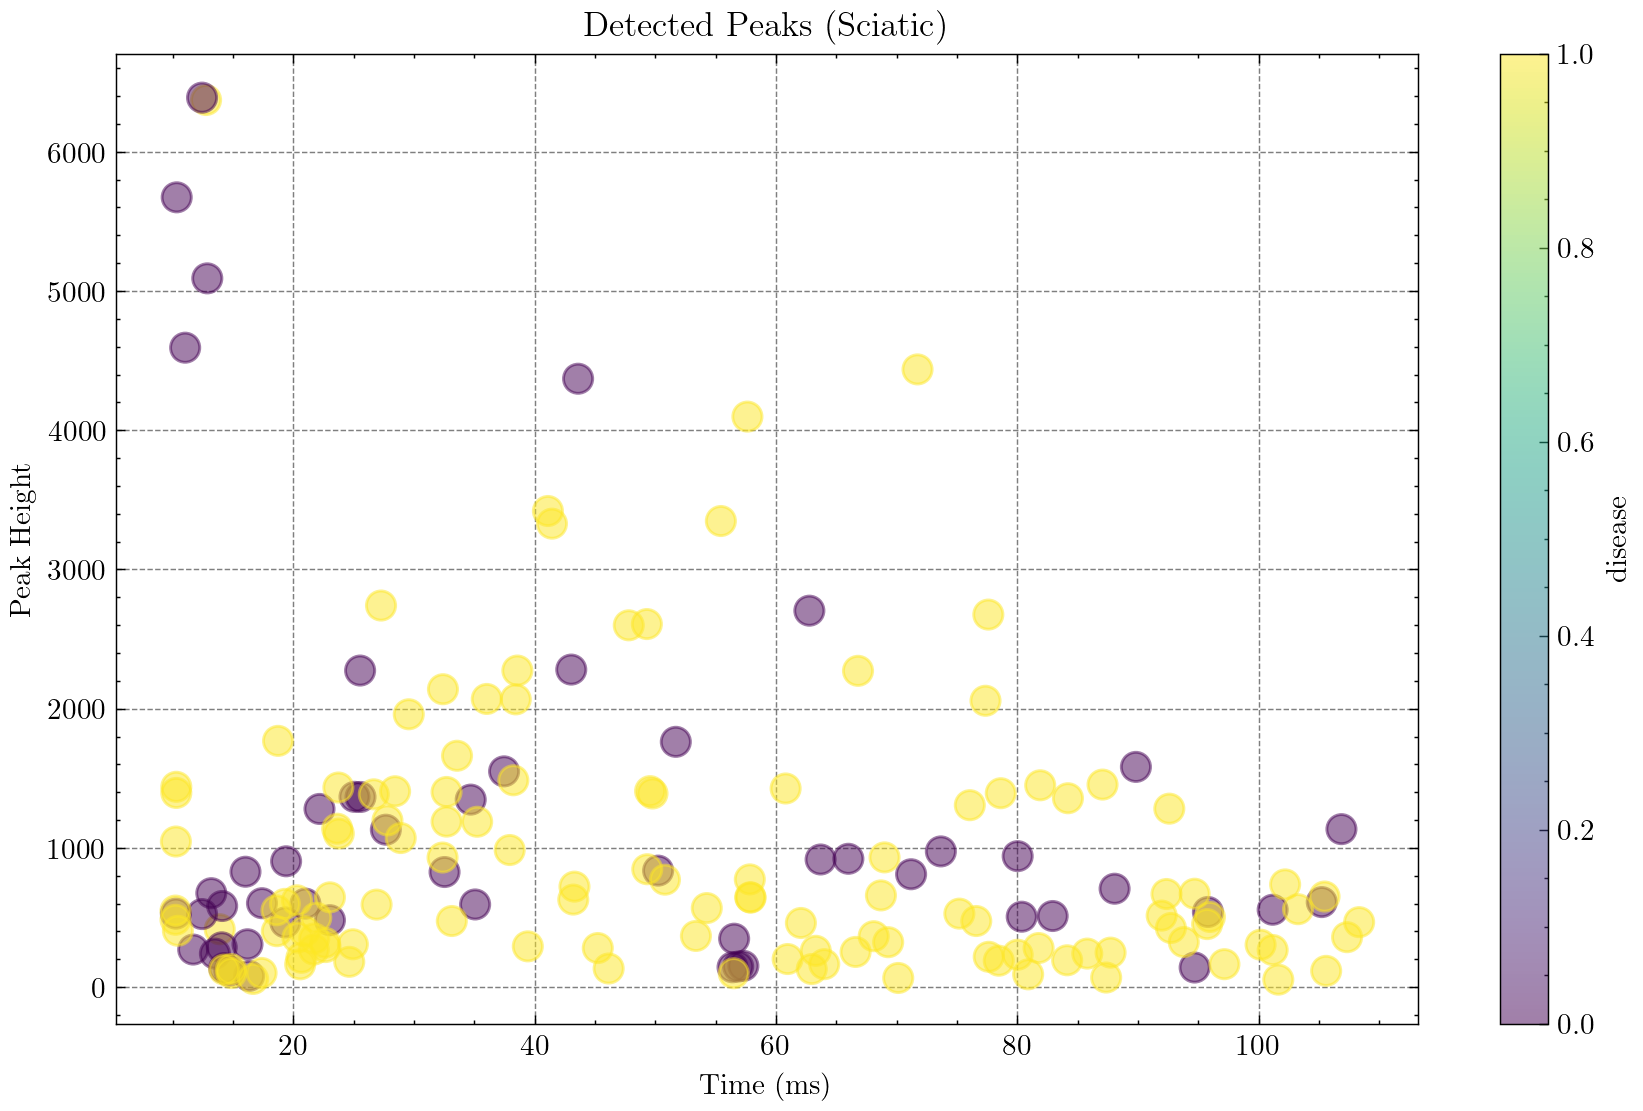

In [9]:
peak_positions_ms = []
peak_heights = []
groups = []

for trial in extracted_peaks:
   for group, peaks in trial.items():
       for position, height in peaks:
           if height < 1000:
               peak_positions_ms.append(position * (1000 / 30000))
               peak_heights.append(height)
               groups.append(group)

# plot with colors based on a variable
plt.figure(figsize=(10, 6), dpi=210)
plt.scatter(peak_positions_ms, peak_heights, c=groups, cmap='viridis', label='Detected Peaks', s=100, alpha = 0.5)
plt.colorbar(label='disease')
plt.xlabel('Time (ms)')
plt.ylabel('Peak Height')
plt.title('Detected Peaks (Sciatic)')
plt.savefig('/Users/fomo/Desktop/peaks.png')
plt.show()

# Generate single large plot

In [ ]:
fig, ax = plt.subplots(n, 1, figsize = (21,7*n), dpi = 210)

for i in tqdm(range(n), desc="Processing trials"):
    
    data_path = os.path.join(master_folder, spreadsheet.session_dates[i], "extracted", "processed_data.pkl")
    peaks_path = os.path.join(master_folder, spreadsheet.session_dates[i], "extracted", "detected_peaks.json")
    
    # temporary data
    with open(data_path, 'rb') as file:
        data = pickle.load(file)
        
    with open(peaks_path, 'rb') as file:
        detected_peaks = json.load(file)
    
    mean_data = np.mean(data[4:8, :, :],axis = 2)
    std_data = np.std(data[4:8, :, :], axis = 2)
    peaks = [peak_position * (1000 / 30000) for _, peak_position, peak_height in detected_peaks if peak_height < 1000]

    # plotting parameters
    time_axis = np.arange(mean_data.shape[1]) * (1000 / 30000)
    tick_positions = np.arange(0, np.max(time_axis), 10)

    for channel_index in range(0,4):

        # plot peaks, mean data and error bars
        upper_bound = mean_data[channel_index] + std_data[channel_index]
        lower_bound = mean_data[channel_index] - std_data[channel_index]
        ax[i].fill_between(time_axis, upper_bound, lower_bound, alpha = 0.3, label =f'Chennal {channel_index + 5}')
        ax[i].plot(time_axis,mean_data[channel_index], label = f'Channel {channel_index + 5}')
        ax[i].plot(peaks, mean_data[channel_index][peaks], "X", label = 'Positive Peaks', color = "purple", ms = 21)

        # plot aesthetics
        ax[i].set_xlabel('Time (ms)')
        ax[i].set_ylabel('Amplitude ($\mu$V)')
        ax[i].set_xticks(tick_positions)
        ax[i].set_ylim(-500,500)
        ax[i].set_title(spreadsheet.session_dates[i])

plt.legend()   
plt.tight_layout()
plt.savefig('/Users/fomo/Desktop/all_sessions.png')